# 問題4

Nonlinear Koopman Modes and Power System Stability Assessment Without Models  
の論文を参考にkoopman mode decompositionを用いてデータ解析を行う．

In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df1 = pd.read_csv('data/data1.csv', header=None)

In [3]:
df2 = pd.read_csv('data/data2.csv', header=None)

In [4]:
df1.head()

,0,1,2,3,4,5,6,7
0,-82.554,-18.8310,-145.240,17.286,50.823,277.840,27.605,27.605
1,-71.382,19.8660,-73.005,45.663,228.830,221.090,43.083,-26.570
2,-132.830,4.3871,-49.788,48.243,226.250,71.461,50.823,-16.251
3,-104.900,27.6050,-147.820,74.040,272.680,182.390,14.706,-18.831
4,-171.930,-3.3521,-36.889,-11.091,164.330,283.000,53.403,-16.251


In [5]:
df2.head()

,0,1,2,3,4,5,6,7
0,2852.0,170.38,77.319,-51.071,-191.56,105.41,240.95,102.700
1,2842.0,169.64,76.612,-50.398,-191.31,105.66,240.85,102.960
2,2838.8,176.95,80.415,-51.570,-192.19,104.87,239.70,104.110
3,2837.4,182.93,88.407,-54.141,-194.46,104.23,238.76,105.020
4,2890.8,167.27,122.000,-67.749,-275.15,160.96,248.01,95.947


In [6]:
#df2.drop(0, axis = 1,inplace=True)

ここでdf1は，power exchange deviations leading to the 2006 system disturbance in the European gridを表しており，df2は，Arizona-Southern California grid outageの各電力時系列を表している

Text(0, 0.5, 'power flow[MW]')

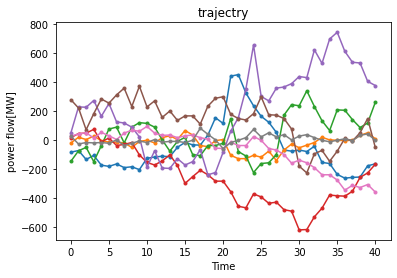

In [7]:
for i in range(df1.shape[1]):
    df1.iloc[:,i].plot(marker = 'o', markersize = 3)
plt.title('trajectry')    
plt.xlabel('Time')
plt.ylabel('power flow[MW]')    

Text(0, 0.5, 'power flow[MW]')

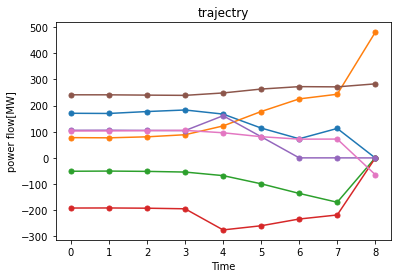

In [8]:
for i in range(df2.shape[1]):
    if i == 0: continue
    df2.iloc[:,i].plot(marker = 'o',markersize = 5)
plt.title('trajectry')    
plt.xlabel('Time')
plt.ylabel('power flow[MW]')

### アルゴリズム
アーノルディ型アルゴリズムによりクープマン固有値，固有関数を求める．

In [9]:
def KMD(X, yn):
    """
    observation vector
    X = [y1, y2, ..., yn-1]
    
    output 
    Koopman eigenvalue, Koopman eigen vector
    """
    c = np.linalg.pinv(X.T@X)@X.T@yn #rank落ちしている場合を考慮してムーアペンローズの擬似逆行列を使う, 
    r = yn - X@c #剰余ベクトル
    n = X.shape[1]  #Koopman eigenvalueの個数
    C = np.zeros((n,n)) 
    C[:,-1] = c
    C[np.arange(n-1)+1,np.arange(n-1)] = 1   #コンパニオン行列
    lam, _ = np.linalg.eig(C)                #Koopman eigenvalue
    T = np.vander(lam,increasing=True)     #vandermond matrix
    V = X@np.linalg.pinv(T)                   #Koopman eigen vector
    return lam, V, T, r

### データ１
まず初めにdf1の欧州でのシステム障害時のデータから解析を行なっていく．  
観測データは8カ国の電力時系列データを一定間隔に40点サンプリングしたものである．

In [10]:
Y = df1.values.T

In [11]:
yn = Y[:,-1]
X = Y[:,:-1]

In [12]:
yn.shape

(8,)

In [13]:
Y.shape

(8, 41)

In [14]:
X.shape

(8, 40)

In [15]:
lam, V, T, r = KMD(X,yn)

(-2.0, 2.0)

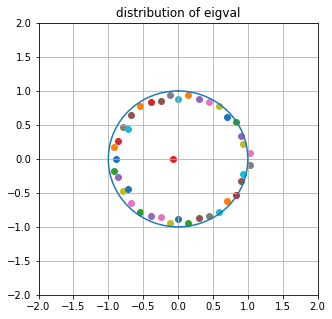

In [16]:
fig = plt.figure(figsize=(5,5))
x,y= [],[]
for j in np.linspace(0, 2 * np.pi, 1000):
      x.append(math.sin(j))
      y.append(math.cos(j))
plt.plot(x,y)    
for l in lam:
    plt.scatter(l.real, l.imag)

plt.title('distribution of eigval')    
plt.grid()
plt.xlim(-2,2)    
plt.ylim(-2,2)

上のKoopman固有値の分布より実部が１を超える不安定な共役な固有値対が存在することがわかる．

In [17]:
np.argwhere(abs(lam) > 1)

array([[36],
       [37]])

In [18]:
T.shape

(40, 40)

Text(0, 0.5, 'power flow[MW]')

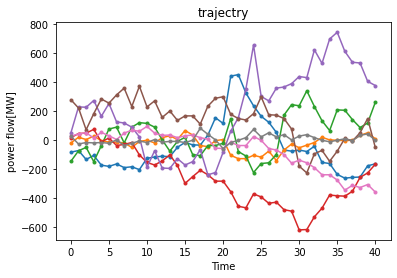

In [19]:
Tp = np.concatenate([T, (lam**(T.shape[0])).reshape(-1,1)], axis = 1)
yhat = V@Tp
yhat[:,-1] += r
for i in range(yhat.shape[0]):
    plt.plot(yhat[i].real, marker = 'o', markersize = 3)
plt.title('trajectry')    
plt.xlabel('Time')
plt.ylabel('power flow[MW]')

ここでクープマン固有値を全て使って(N=40)時系列データy0,...,ynを予測すると上で示したような時系列データを再現することができた．  
また，固有値分布において実部が1を超える不安定モード(36,37番目)に対して時系列データをプロットすると以下のようになる．

Text(0, 0.5, 'power flow[MW]')

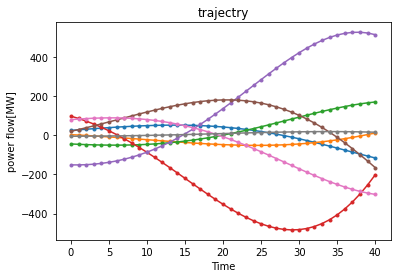

In [20]:
Tp = np.concatenate([T, (lam**(T.shape[0])).reshape(-1,1)], axis = 1)
yhat = V[:,(36,37)]@Tp[(36,37),:]
yhat[:,-1] += r
for i in range(yhat.shape[0]):
    plt.plot(yhat[i].real, marker = 'o', markersize = 3)
plt.title('trajectry')    
plt.xlabel('Time')
plt.ylabel('power flow[MW]')

元々の時系列データから見るとtimestep20を超えたあたりから異常が発生し始めたことが確認できるが，モード分解による不安定モードの可視化(上図)から赤線や紫線の国がtimestep20以前から異常な挙動を示していることが見て取れる．

### データ2
続いてカリフォルニアでの停電での時系列データについて解析を行っていく．  
今回は8本の異なるラインにおける電力時系列データを9点用いてクープマンモード分解を行う．

In [21]:
Y = df2.values.T

In [22]:
yn = Y[:,-1]
X = Y[:,:-1]

In [23]:
yn.shape

(8,)

In [24]:
Y.shape

(8, 9)

In [25]:
X.shape

(8, 8)

In [26]:
lam, V, T, r = KMD(X,yn)

(-6.0, 6.0)

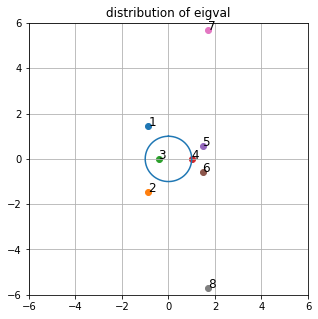

In [27]:
fig = plt.figure(figsize=(5,5))
label = np.arange(1,lam.size+1)
x,y= [],[]
for j in np.linspace(0, 2 * np.pi, 1000):
      x.append(math.sin(j))
      y.append(math.cos(j))
plt.plot(x,y)    
for i,l in enumerate(lam):
    plt.scatter(l.real, l.imag)
    plt.text(l.real, l.imag, label[i], fontsize=12)

plt.title('distribution of eigval')    
plt.grid()
plt.xlim(-6,6)    
plt.ylim(-6,6)

In [28]:
T = np.vander(lam,increasing=True)
yhat = V@T

Text(0, 0.5, 'power flow[MW]')

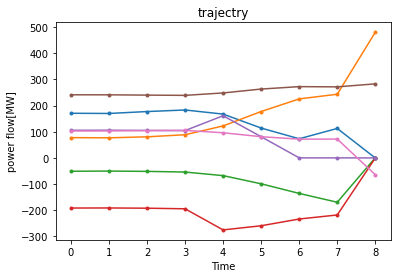

In [29]:
Tp = np.concatenate([T, (lam**(T.shape[0])).reshape(-1,1)], axis = 1)
yhat = V@Tp
yhat[:,-1] += r
for i in range(yhat.shape[0]):
    if i == 0:continue
    plt.plot(yhat[i].real, marker = 'o', markersize = 3)
plt.title('trajectry')    
plt.xlabel('Time')
plt.ylabel('power flow[MW]')

先程と同様にクープマンモードすべて(n=8)を使った場合には元の時系列が復元できていることが確認される．  
また，不安定モードである{1,2}, {5,6}の固有値対についてモードを用いて時系列をプロットしたものを下に示す．

まず初めに{1,2}の不安定モードについて

Text(0, 0.5, 'power flow[MW]')

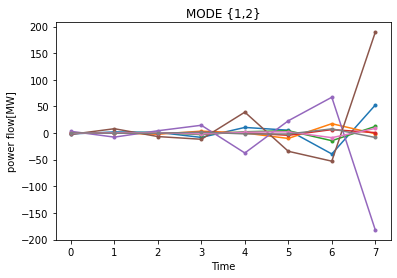

In [30]:
Tp = np.concatenate([T, (lam**(T.shape[0])).reshape(-1,1)], axis = 1)
yhat = V[:,(0,1)]@Tp[(0,1),:]
yhat[:,-1] += r
for i in range(yhat.shape[0]):
    plt.plot(yhat[i,:-1].real, marker = 'o', markersize = 3)
plt.title('MODE {1,2}')    
plt.xlabel('Time')
plt.ylabel('power flow[MW]')

グラフより紫色の電力ラインと茶色の電力ラインが互いに逆位相で振動していることがわかる．  
続いて{5,6}の不安定モードについて

Text(0, 0.5, 'power flow[MW]')

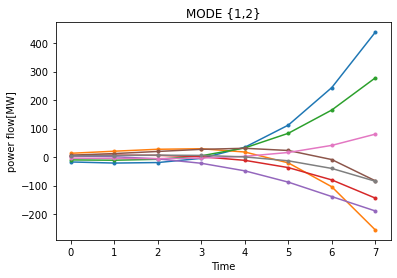

In [31]:
Tp = np.concatenate([T, (lam**(T.shape[0])).reshape(-1,1)], axis = 1)
yhat = V[:,(4,5)]@Tp[(4,5),:]
yhat[:,-1] += r
for i in range(yhat.shape[0]):
    plt.plot(yhat[i,:-1].real, marker = 'o', markersize = 3)
plt.title('MODE {1,2}')    
plt.xlabel('Time')
plt.ylabel('power flow[MW]')

グラフよりこのモードは全てのラインにおいてゆっくりと不安定になっていくモードを表していることが読み取れる．

# 問題6
クープマン作用素に関する非線形力学系の方法論の自分の研究課題への適用可能性を具体的に論ぜよ．

私の卒業研究テーマはデータ同化アルゴリズムの一つであったため，まず，データ同化の枠組みにおいてKoopman作用素の適用について考察を行う．  
データ同化ではオンライン，オフラインに限らずに，対象としているモデルの支配方程式を仮定して状態変数の時間発展を計算する．  
カルマンフィルターなどの逐次データ同化の枠組みであれば，授業で扱ったように観測時系列データからクープマン固有値，固有関数を計算して，クープマン作用素を用いて未来の時系列を予測し，予測された時系列と新たに得られた観測量を元にフィルタリングによって状態変数を更新する方法などが考えられる．  
四次元変分法などの非逐次の場合は主にパラメータも含めた初期値を推定することが目的となる．一方でクープマン作用素の枠組みでは初期値(x(0))は与えられたものとして時系列の計算を行っていくので，最適な初期値の探索も含めるような枠組みが必要だと思った．  
さらにデータだけからクープマン作用素を用いて時系列予測するのではなく，予め物理モデルをある程度仮定して，そのモデルでは表せない剰余項をクープマン作用素で表現するようなモデル駆動とデータ駆動の融合も考えられる．  
また，ハミルトニアンニューラルネット[1]のように保存量（拡散方程式における熱量など）を考慮した時系列予測を行うクープマン作用素なども考えられるとよりデータノイズに対してロバストな時系列予測ができるようになると思った．

さらに，自分が卒業研究で行っていた四次元変分法は深層学習において中間層を微分方程式に置き換えたNeural ODE[2]というモデルに用いられている．  
このモデルは時系列予測などで高い性能を示しており，従来の離散層のニューラルネットに比べてパラメータ効率(より少ないパラメータで同程度のパフォーマンスが可能)が良いこと．報告されている．  
また，クープマン固有関数の辞書をニューラルネットで求めるような研究[3]も行われている．  
EDMDの辞書学習においてNeural ODEを持ちいれば従来研究よりもパラメータ効率の良い枠組みができる可能性がある．

## 参考文献
[1]Samuel Greydanus, Misko Dzamba, and Jason Yosinski. Hamiltonian neural networks. In Advances in Neural Information Processing Systems, pp. 15353–15363, 2019  
[2]Ricky T. Q. Chen et al. “Neural Ordinary Differential Equations”. In: Advances in Neural Information Processing Systems.  
[3]Li Q, Dietrich F, Bollt EM, Kevrekidis IG. 2017. Extended dynamic mode decomposition with dictionary learning: a data-driven adaptive spectral decomposition of the Koopman operator. Chaos 27:103111  


# 問題7
講義の感想

私は今年の修論発表会で隣の研究室の先輩(白坂先生の所)がKoopman作用素の辞書学習にNeural ODEを使ってやっていたのを聞き，(上述)DMDに興味を持ったので本講義を受講しようと思いました．  
私自身，学部は工学部だったので関数解析，力学系の知識がほぼゼロの状態でしたが，事前知識がなくてもわかりやすく講義していただき，とても楽しく勉強させていただきました．  
クープマン作用素の理論としては，同じデータ駆動モデリングの深層学習とは異なり，得られた固有値からある程度のシステムの不安定性などの示唆が得られる点が説明可能性という観点で優れていて面白いと感じました．  
さらに，ペロンフロベニウス作用素についても興味を持ったので今後勉強をすすめていきたいと思いました．  
半年間授業していただきありがとうございました．  
また，SCI'21でもお世話になり，ありがとうございました．  
またお会いする機会があればよろしくお願い致します．